Modification of NuScenes Qualitative.ipynb file to plot forecasts on top of nuScenes map.

In [2]:
%matplotlib inline
import sys
sys.path.append('../../trajectron')
import os
import numpy as np
import torch
import dill
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from helper import *
import visualization
from model.dataset import *
from model.components import *
from model.model_utils import *

AGENT_COLORS = [
        'blue', 'darkviolet', 'dodgerblue', 'darkturquoise',
        'green', 'olive', 'gold', 'orange', 'red', 'deeppink']
AGENT_COLORS = np.array(AGENT_COLORS) \
        .take([(i * 3) % len(AGENT_COLORS) for i in range(17)], 0)

NCOLORS = len(AGENT_COLORS)

In [3]:
# Load nuScenes SDK
nuScenes_data_path = "/home/fireofearth/code/robotics/trajectron-plus-plus/experiments/nuScenes/v1.0"
# Data Path to nuScenes data set
nuScenes_devkit_path = './devkit/python-sdk/'
sys.path.append(nuScenes_devkit_path)
from nuscenes.map_expansion.map_api import NuScenesMap
nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name='boston-seaport')

In [4]:
# Load dataset
with open('../processed/nuScenes_test_full.pkl', 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes

In [5]:
# Load model
ph = 6
log_dir = './models'
model_dir = os.path.join(log_dir, 'int_ee_me')
# model_dir = os.path.join(log_dir, 'int_ee')
eval_stg, hyp = load_model(
    model_dir, eval_env, ts=12)


Loading from ./models/int_ee_me/model_registrar-12.pt
Loaded!



### Combining forecast and map

1 Vehicles
Map centered on node VEHICLE/ego


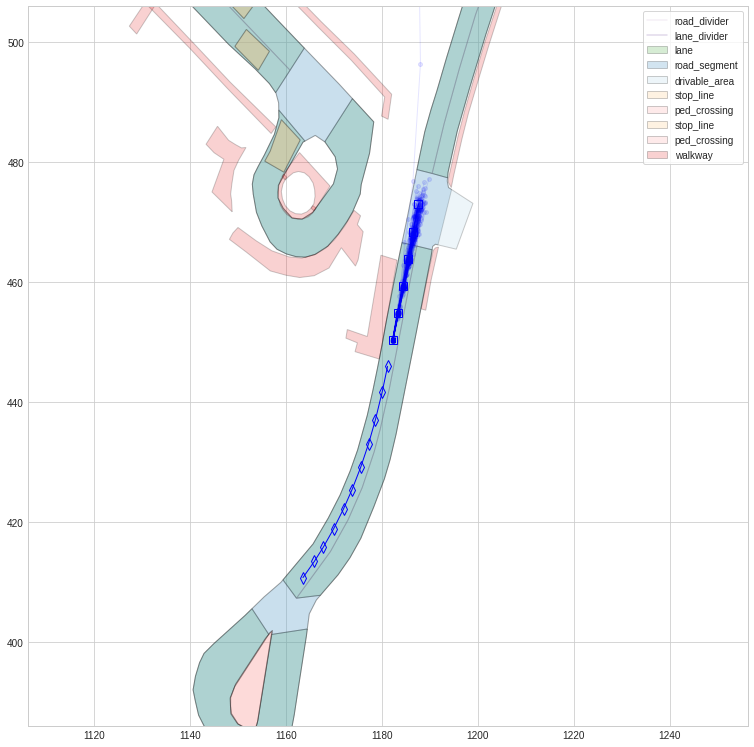

In [23]:
scene = eval_scenes[1]
# scenes_to_use = ['14']
# sel_scenes = list(filter(lambda s : s.name in scenes_to_use, eval_scenes))
# scene = sel_scenes[0]
ph = 6
num_samples = 100
t = 11
timesteps = np.array([t])

with torch.no_grad():
    predictions = eval_stg.predict(scene,
            timesteps, ph, num_samples=num_samples,
                z_mode=False,
                gmm_mode=False,
                full_dist=False,
                all_z_sep=False)

prediction_dict, histories_dict, futures_dict = \
    prediction_output_to_trajectories(
        predictions, dt=scene.dt, max_h=10, ph=ph, map=None)

v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[t].keys()))
v_nodes.sort(key=lambda k: 0 if 'ego' in repr(k) else 1)
# node = next(filter(lambda k: 'ego' in repr(k), v_nodes))
node = v_nodes[0]

print(f"{len(v_nodes)} Vehicles")
print("Map centered on node", node)

minpos = np.array([scene.x_min, scene.y_min])
ego_lastpos = histories_dict[t][node][-1]
ego_lastx = ego_lastpos[0]
ego_lasty = ego_lastpos[1]
center = np.array([
    scene.ego_initx + ego_lastx,
    scene.ego_inity + ego_lasty])

center = minpos + ego_lastpos
viewport_hw = 50
my_patch = (center[0] - viewport_hw, center[1] - viewport_hw,
            center[0] + viewport_hw, center[1] + viewport_hw)
if scene.map_name != nusc_map.map_name:
    nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name=scene.map_name)
fig, ax = nusc_map.render_map_patch(my_patch, scene.layer_names,
        figsize=(10, 10), alpha=0.2, render_egoposes_range=False)

for idx, node in enumerate(v_nodes):
    player_future = futures_dict[t][node]
    player_past = histories_dict[t][node]
    player_predict = prediction_dict[t][node]
    player_future += minpos
    player_past += minpos
    player_predict += minpos

    ax.plot(player_future[:,0], player_future[:,1],
                marker='s', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    ax.plot(player_past[:,0], player_past[:,1],
                marker='d', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    for row in player_predict[0]:
        ax.plot(row[:,0], row[:,1],
                marker='o', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, alpha=0.1, markersize=4)

### Latents to forecasts

In [24]:
def generate_vehicle_latents(
            num_samples = 200,
            z_mode=False, gmm_mode = False, full_dist = False, all_z_sep = False):
    # Trajectron.predict() arguments
    min_future_timesteps = 0
    min_history_timesteps = 1

    node_type = eval_stg.env.NodeType.VEHICLE
    if node_type not in eval_stg.pred_state:
        raise Exception("fail")

    model = eval_stg.node_models_dict[node_type]

    # Get Input data for node type and given timesteps
    batch = get_timesteps_data(env=eval_stg.env, scene=scene, t=timesteps, node_type=node_type,
                               state=eval_stg.state,
                               pred_state=eval_stg.pred_state, edge_types=model.edge_types,
                               min_ht=min_history_timesteps, max_ht=eval_stg.max_ht,
                               min_ft=min_future_timesteps,
                               max_ft=min_future_timesteps, hyperparams=eval_stg.hyperparams)
    
    # There are no nodes of type present for timestep
    if batch is None:
        raise Exception("fail")

    (first_history_index,
     x_t, y_t, x_st_t, y_st_t,
     neighbors_data_st,
     neighbors_edge_value,
     robot_traj_st_t,
     map), nodes, timesteps_o = batch

    x = x_t.to(eval_stg.device)
    x_st_t = x_st_t.to(eval_stg.device)
    if robot_traj_st_t is not None:
        robot_traj_st_t = robot_traj_st_t.to(eval_stg.device)
    if type(map) == torch.Tensor:
        map = map.to(eval_stg.device)

    # MultimodalGenerativeCVAE.predict() arguments
    inputs = x
    inputs_st = x_st_t
    first_history_indices = first_history_index
    neighbors = neighbors_data_st
    neighbors_edge_value = neighbors_edge_value
    robot = robot_traj_st_t
    prediction_horizon = ph

    mode = ModeKeys.PREDICT

    x, x_nr_t, _, y_r, _, n_s_t0 = model.obtain_encoded_tensors(mode=mode,
                                                               inputs=inputs,
                                                               inputs_st=inputs_st,
                                                               labels=None,
                                                               labels_st=None,
                                                               first_history_indices=first_history_indices,
                                                               neighbors=neighbors,
                                                               neighbors_edge_value=neighbors_edge_value,
                                                               robot=robot,
                                                               map=map)

    model.latent.p_dist = model.p_z_x(mode, x)
    z, num_samples, num_components = model.latent.sample_p(num_samples,
                                                          mode,
                                                          most_likely_z=z_mode,
                                                          full_dist=full_dist,
                                                          all_z_sep=all_z_sep)
    
    _, predictions = model.p_y_xz(mode, x, x_nr_t, y_r, n_s_t0, z,
                                            prediction_horizon,
                                            num_samples,
                                            num_components,
                                            gmm_mode)
    z = z.cpu().detach().numpy()
    zz = z
    # z has shape (number of samples, number of vehicles, number of latent values)
    # z[i,j] gives the latent for sample i of vehicle j
#     print(z.shape)
    
    predictions = predictions.cpu().detach().numpy()
    # predictions has shape (number of samples, number of vehicles, prediction horizon, D)
#     print(predictions.shape)

    predictions_dict = dict()
    for i, ts in enumerate(timesteps_o):
        if ts not in predictions_dict.keys():
            predictions_dict[ts] = dict()
        predictions_dict[ts][nodes[i]] = np.transpose(predictions[:, [i]], (1, 0, 2, 3))
    
    z = np.swapaxes(np.argmax(z, axis=-1), 0, 1)
    predictions = np.swapaxes(predictions, 0, 1)
        
    return z, zz, predictions, nodes, predictions_dict

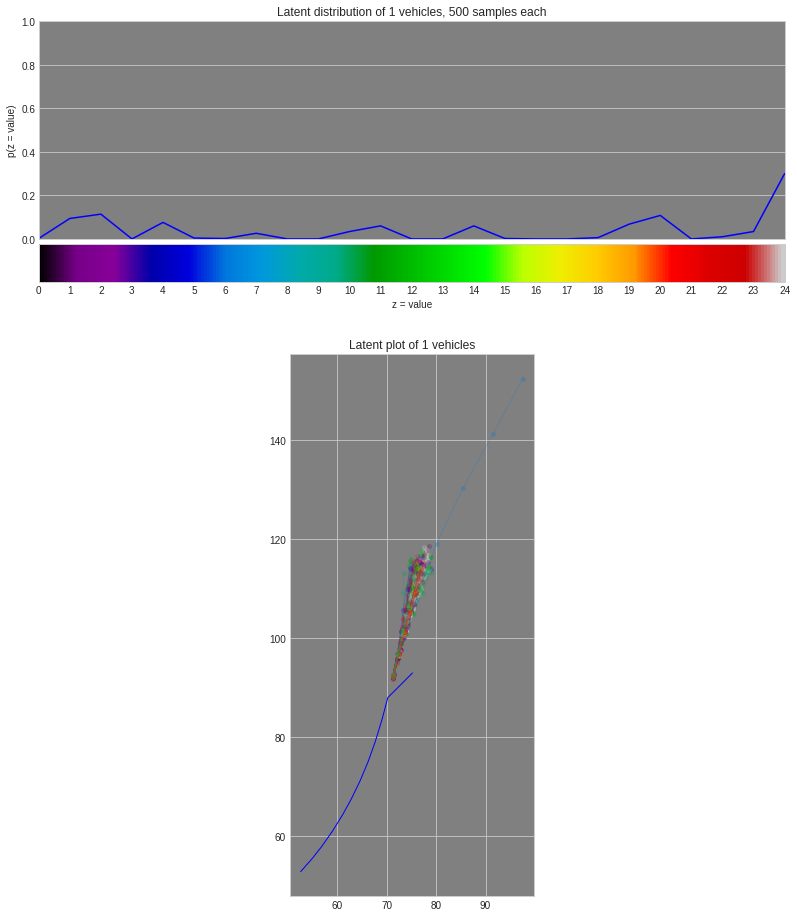

In [25]:
colors = cm.nipy_spectral(np.linspace(0, 1, 25))

z,zz, predictions, nodes, predictions_dict = generate_vehicle_latents(
        num_samples=500,
        z_mode=False, gmm_mode = False,
        full_dist = False, all_z_sep = False)

# print("shape of arrays", z.shape, predictions.shape)
z_counts = np.sum(zz, axis=0) / z.shape[1]
n_vehicles = len(nodes)

_, histories_dict, _ = \
    prediction_output_to_trajectories(
        predictions_dict, dt=scene.dt, max_h=10, ph=ph, map=None)

fig, (ax1, ax) = plt.subplots(2, 1, figsize=(11, 16))
fig.tight_layout()

ax1.set_facecolor("grey")
for idx, zz in enumerate(z_counts):
    ax1.plot(range(25), zz, c=AGENT_COLORS[idx % NCOLORS])
ax1.set_xlim([0, 24])
ax1.set_ylim([0, 1])
ax1.set_aspect(7)
ax1.set_ylabel("p(z = value)")
ax1.set_title(f"Latent distribution of {n_vehicles} vehicles, {z.shape[1]} samples each")
ax1.get_xaxis().set_ticks([])

scalarmappaple = cm.ScalarMappable(cmap=cm.nipy_spectral)
scalarmappaple.set_array(range(0, 25))
plt.colorbar(scalarmappaple, ax=ax1, orientation='horizontal',
             pad=0.01,
             ticks=range(0, 25),
             label="z = value")

ax.set_facecolor("grey")
ax.set_title(f"Latent plot of {n_vehicles} vehicles")
ax.set_aspect('equal')

for idx, node in enumerate(nodes):
    player_past = histories_dict[t][node]
    player_past = np.vstack((player_past, player_past[-1][None] + 5))

    ax.plot(player_past[:,0], player_past[:,1],
            color=AGENT_COLORS[idx % NCOLORS],
            linewidth=1)

    zn = z[idx]
    pn = predictions[idx]
    for jdx in range(zn.shape[0]):
        color = colors[zn[jdx]]
        ax.plot(pn[jdx, :, 0], pn[jdx, :, 1],
                marker='o',
                 color=color,
                linewidth=1, alpha=0.2, markersize=4)

In [26]:
def plot_behavior(z, predictions, nodes, behaviors):
    colors = cm.nipy_spectral(np.linspace(0, 1, 25))
    fig, ax = plt.subplots(figsize=(11, 11))
    ax.set_facecolor("grey")
    ax.set_title(f"Latent dist. of {n_vehicles} vehicles")
    ax.set_aspect('equal')
    for behavior in behaviors:
        label=f'{behavior}'
        for idx, node in enumerate(nodes):
            zn = z[idx]
            pn = predictions[idx]
            mask = zn == behavior
            zn = zn[mask]
            pn = pn[mask]

            for jdx in range(zn.shape[0]):
                color = colors[behavior]
                plt.plot(pn[jdx, :, 0], pn[jdx, :, 1],
                        marker='o', color=color,
                        linewidth=1, alpha=0.2, markersize=4,
                        label=label)
                label=None
    ax.legend(loc='best')
    return fig, ax

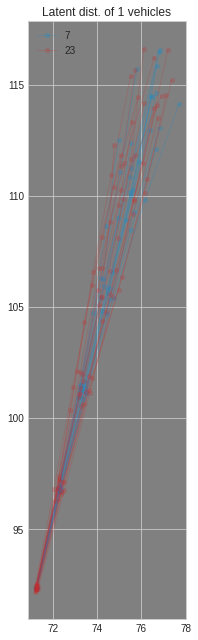

In [27]:
behaviors = [7,23]
fig, ax = plot_behavior(z, predictions, nodes, behaviors)

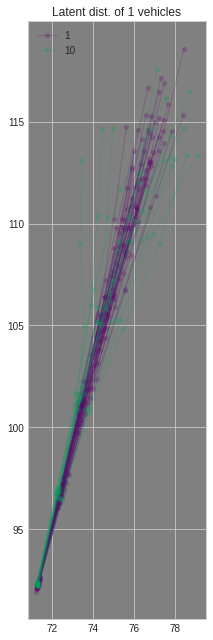

In [28]:
behaviors = [1,10]
fig, ax = plot_behavior(z, predictions, nodes, behaviors)

In [29]:
def plot_behavior(z, predictions, nodes):
    coords = predictions.reshape(-1, 2)
    x_max, y_max = np.amax(coords, axis=0)
    x_min, y_min = np.amin(coords, axis=0)
    figwidth  = 20.
    figheight = figwidth*(13. / 2.)*(y_max - y_min)/(x_max - x_min)
    print(figheight)
    
    _, histories_dict, _ = \
            prediction_output_to_trajectories(
                predictions_dict, dt=scene.dt, max_h=10, ph=ph, map=None)
    
    n_vehicles = len(nodes)
    colors = cm.nipy_spectral(np.linspace(0, 1, 25))
    fig, axes = plt.subplots(13, 2,
            figsize=(figwidth, figheight))
    fig.tight_layout()
    
    for behavior in range(0, 25):
        ax = axes[behavior // 2][behavior % 2]
        color = colors[behavior]
        label=f"z = {behavior}"
        for idx, node in enumerate(nodes):
            zn = z[idx]
            pn = predictions[idx]
            mask = zn == behavior
            zn = zn[mask]
            pn = pn[mask]
            player_past = histories_dict[t][node]
            player_past = np.vstack(
                    (player_past, player_past[-1][None] + 5))
            
            ax.plot(player_past[:,0], player_past[:,1],
                    color=AGENT_COLORS[idx % NCOLORS],
                    linewidth=1)
            
            for jdx in range(zn.shape[0]):
                ax.plot(pn[jdx, :, 0], pn[jdx, :, 1],
                        marker='o', color=color,
                        linewidth=1, alpha=0.2, markersize=4,
                        label=label)
                label=None
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        ax.set_aspect('equal')
        ax.legend(loc='upper right')
        ax.set_facecolor("grey")
    axes[-1,-1].set_xlim([x_min, x_max])
    axes[-1,-1].set_ylim([y_min, y_max])
    axes[-1,-1].set_visible(False)
    return fig, axes

300.38819286339213


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


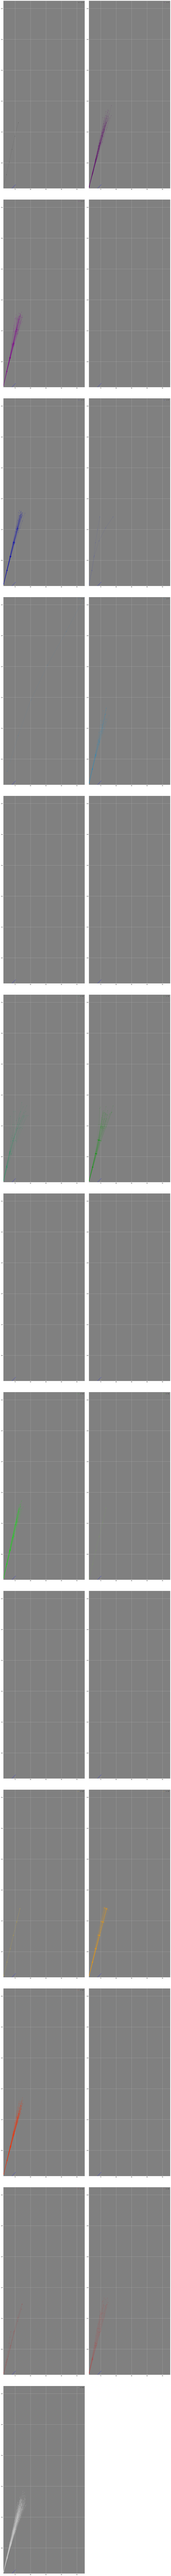

In [30]:
fig, ax = plot_behavior(z, predictions, nodes)

In [22]:
np.min(1,2)

AxisError: axis 2 is out of bounds for array of dimension 0